In [2]:
import re
import nltk
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [3]:
!pip install nltk

/bin/bash: /home/efernand/anaconda3/envs/OptimalTransport/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# 1. Introduction

__An overview of Existing Libraries.__ 

- [NLTK](https://www.nltk.org/): Is an open-source __ensemble__ of libraries, datasets and tutorials written in Python, that also constitutes a single library used in natural language processing. It was originally intended for __educational purposes__.
- [spaCy](https://spacy.io/): Is an open-source library written in Python + Cython, which focuses on software for production.
- [Gensim](https://radimrehurek.com/gensim/): Is an open-source library writtein in Python + Cython, which focuses on unsupervised learning over texts, like topic modeling and document indexing and retrieval.
- [Hugging Face](https://huggingface.co/): Is a french-american company (and also a Python library) that focuses on open-source, collaborative machine learning on text. [It hosts many libraries](https://huggingface.co/docs/hub/models-libraries) that focuses around deep learning for natural language modeling.

__Def (biased, vague).__ Natural Language Processing (NLP) is a field of computer science that seeks to make computers understand natural/human language.

__A Philosophical Detour.__ In epistemology, there are mainly two views on how true knowledge is originated,

- Rationalism, which dictates that knowledge comes from intellectual, deductive reasoning,
- Empiricism, which dictates that knowledge comes from sensory experience.

These two approaches can be seen as two sides of a coin. For instance, rationalism was defended by René Descartes, whereas Empiricism was defendend by David Hume. A bridge was latter drawn by Kant's Critique of Pure Reason, who claimed that "knowledge begins with the senses, but ends with reason".

An analogy can be made between these opposing views and early approaches in natural language processing. In the mid 20th century, inspired by linguists such as [Fernand de Sassure](https://en.wikipedia.org/wiki/Ferdinand_de_Saussure), philospher [Ludwig Wittgenstein](https://en.wikipedia.org/wiki/Ludwig_Wittgenstein) and the theory of linguistics, computer scientists tried to model natural language through gramatical rules and other "rationalist tools". This led to the development of symbolic NLP, in line with the role that symbolic AI played at that time. Note that, with this approach, patterns are not learned from data, but are rather constructed by the scientist/designer. An exponent of such approach is the philosopher [Noam Chomsky](https://en.wikipedia.org/wiki/Noam_Chomsky).

> A rationalist approach is characterized by the belief that a significant part of the knowledge in the human mind is not derived by the senses, but is fixed in advance, presumably by genetic inheritance. Within AI, rationalist beliefs can be seen as __support the attempt to create intelligent systems by handcoding into them a lot of starting knowledge and reasoning mechanisms, so as to duplicate what the human brain begins with__. Manning, C., & Schutze, H. (1999). Foundations of statistical natural language processing. MIT press.

In contrast with this "rationalist approach", the empiricist approach is widespread in various fields of science since a long time. In the context of NLP, this approach has seen a resurgence since the 90's, first through statistical NLP, then through __neural NLP__.

> An empiricist approach to NLP suggests that we can learn the complicated and extensive structure of language by specifying an appropriate general general language model, and then inducing the values of parameters by applying statistical, pattern recognition and machine learning methods to a large amount of language use. Manning, C., & Schutze, H. (1999). Foundations of statistical natural language processing. MIT press.

Overall, statistical NLP uses the tools of statistics and probability to analyze text. A natural "evolution" of this approach is considering neural nets for parametrizing complex functions.

__Food for thought.__ In the context of the recent boom of LLMs, what do you think about the design of artificial intelligence? Will machines become intelligent when we have enough data/computation? A provocative way to pose this question is through ["Is scale all you need?"](https://www.linkedin.com/posts/yann-lecun_i-have-claimed-that-auto-regressive-llms-activity-7045908925660950528-hJGk/) Also, think about how neural nets parametrize functions. In the case of a CNN, true, we can fit virtually anything, but doesn't convolutional layers "bias" the network into learning certain types of structures of data?

__Landscape of NLP Problems.__

- __Document Classifcation.__ Given a set of documents $\mathcal{D} = [D_{1},\cdots,D_{n}]$ __corpus of documents__, such that $D_{i} = [w_{i,1},\cdots,w_{i,n_{i}}]$, where $w_{i,j}$ corresponds to the j-th word of the i-th document, guess the class $y_{i} \in \{1,\cdots,n_{c}\}$ of $D_{i}$.
- __Information Retrieval.__ Let $\mathcal{D} = [D_{1},\cdots,D_{n}]$ be a __corpus of documents__, and $D_{0}$ be a __query__. Find $i^{\star}$ s.t. $d(D_{0}, D_{i^{\star}}) \leq d(D_{0}, D_{j})$, $\forall j$.
- __Topic Modeling.__ Let $\mathcal{D} = [D_{1},\cdots,D_{n}]$ be a __corpus of documents__. Decompose $\mathcal{D}$ into $K < n$ topics $\mathcal{T} = [T_{1},\cdots,T_{K}]$ s.t. $T_{k} = [w_{k,1},\cdots,w_{k,n_{k}}]$

__Intersection Problems.__

- Speech Processing:
    - __Text to Speech.__ Generate speech from a textual input,
    - __Speech Reconigition.__ Generate text that transcribes an audio file,
- Image Processing:
    - __Image Captioning.__ Generate a caption (text) that describes an image,
    - __Image Generation.__ From a text describing an image (a prompt), generate an image.

In this lecture, we're going to deal with __sentiment analysis__.

# Interlude

Henceforth we will use the __financial phrasebook__ dataset, available in [Hugging Face](https://huggingface.co/datasets/financial_phrasebank), and which is described in the following Paper,

> Malo, P., Sinha, A., Korhonen, P., Wallenius, J., & Takala, P. (2014). Good debt or bad debt: Detecting semantic orientations in economic texts. Journal of the Association for Information Science and Technology, 65(4), 782-796.

Download the data and place in the data folder at the root of this repository.

# 2. Pre-Processing

In [1]:
with open('../data/Sentences_AllAgree.txt', 'r', encoding="ISO-8859-1") as f:
    raw_data = f.read()

In [4]:
lines = raw_data.split('\n')

First, let us look what the lines of this file look like,

In [5]:
lines[0]

'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral'

In [6]:
lines[1]

"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .@positive"

Lines are structured as follows: the sentence comes first, then "@" marks the label of the sentence (@neutral, @negative, @positive). We can proceed to split these into a data matrix, and a label matrix,

In [7]:
label_mapping = {
    'negative': -1,
    'neutral': 0,
    'positive': +1
}

In [8]:
sentences = []
labels = []
for line in lines[:-1]:
    sentence, label = line.split('@')
    sentences.append(sentence)
    labels.append(label_mapping[label])

In [9]:
sentences = np.array(sentences)
labels = np.array(labels)

We begin by checking whether classes are balanced or not. To that end, we count how many samples each class has, and normalize by the total amount of samples in each partition,

In [10]:
u, c = np.unique(labels, return_counts=True)
print(u, c, c / c.sum())

[-1  0  1] [ 303 1391  570] [0.13383392 0.61439929 0.25176678]


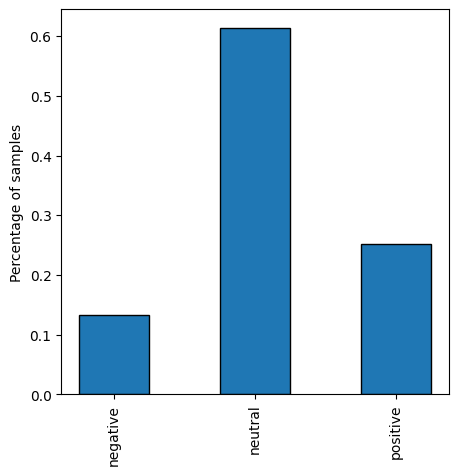

In [36]:
plt.figure(figsize=(5, 5))

plt.bar(u, c / c.sum(), width=.5, edgecolor='k')
plt.ylabel('Percentage of samples')

_ = plt.xticks(u, ['negative', 'neutral', 'positive'], rotation=90)

There is a major imbalance in the data, as most sentences (over 60\%) are neutral. This poses challenges when trying to predict the sentiment of a sentence, but we are not going to consider this at this point.

Our first step is getting the individual words in each sentence, a process known as tokenization.

## 2.1. Tokenization

Tokenization corresponds to the process of breaking a larger object into sub-parts, or tokens. In Natural Language Processing, tokens may vary. For instance, one may perform analysis at three levels,

- Character
- Word
- Sentence

The idea is that a sentence is a set of words, and a word is a set of characters. In this sense, the character is the atom of NLP, analogous to pixels in image processing. Nonetheless, NLP usually performs analysis at the level of words. Henceforth, we will mention "tokenization" to the process of breaking chunks of texts into its individual words. We can do so with NLTK,

In [38]:
help(nltk.tokenize)

Help on package nltk.tokenize in nltk:

NAME
    nltk.tokenize - NLTK Tokenizer Package

DESCRIPTION
    Tokenizers divide strings into lists of substrings.  For example,
    tokenizers can be used to find the words and punctuation in a string:
    
        >>> from nltk.tokenize import word_tokenize
        >>> s = '''Good muffins cost $3.88\nin New York.  Please buy me
        ... two of them.\n\nThanks.'''
        >>> word_tokenize(s) # doctest: +NORMALIZE_WHITESPACE
        ['Good', 'muffins', 'cost', '$', '3.88', 'in', 'New', 'York', '.',
        'Please', 'buy', 'me', 'two', 'of', 'them', '.', 'Thanks', '.']
    
    This particular tokenizer requires the Punkt sentence tokenization
    models to be installed. NLTK also provides a simpler,
    regular-expression based tokenizer, which splits text on whitespace
    and punctuation:
    
        >>> from nltk.tokenize import wordpunct_tokenize
        >>> wordpunct_tokenize(s) # doctest: +NORMALIZE_WHITESPACE
        ['Good', 'muff

In [11]:
sentences

array(['According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
       "For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",
       'In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .',
       ...,
       'LONDON MarketWatch -- Share prices ended lower in London Monday as a rebound in bank stocks failed to offset broader weakness for the FTSE 100 .',
       'Operating profit fell to EUR 35.4 mn from EUR 68.8 mn in 2007 , including vessel sales gain of EUR 12.3 mn .',
       'Sales in Finland decreased by 10.5 % in January , while sales outside Finland dropped by 17 % .'],
      dtype='<U315')

In [12]:
tokens = nltk.tokenize.word_tokenize(sentences[0])
print(tokens)

['According', 'to', 'Gran', ',', 'the', 'company', 'has', 'no', 'plans', 'to', 'move', 'all', 'production', 'to', 'Russia', ',', 'although', 'that', 'is', 'where', 'the', 'company', 'is', 'growing', '.']


Before proceeding, we need to apply some level of preprocessing to the strings. The pre-processing steps are essential in NLP, and indeed they affect the success and validity of models learned on such data. The first step we are going to apply is known as __string normalization__. We will do the following,

- Convert characters to lower-case
- Remove punctuation

In [13]:
x = sentences[0]

In [14]:
print(x)

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


preprocessing is an inherently __heuristic process__. One analyses the data, then decides which steps are necessary to take.

In [15]:
x.lower().strip()

'according to gran , the company has no plans to move all production to russia , although that is where the company is growing .'

here, we are going to lowercase the string, then we remove punctuation. We are going to remove punctuation through [__Regular Expressions (RegEx)__](https://en.wikipedia.org/wiki/Regular_expression). This process uses __meta characters__ to express how to match patterns in text. We can easily remove punctuation using,

```[^\w\s]```

The symbol ```^``` means "start with". ```\w``` means "any word character" (a, ..., z) and (0, ..., 9). ```\s``` means a white space. The brackets indicate that we take a set of character. In this case we are matching any set of characters that starts with a word character and whitespace, i.e., a word.

In [16]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('  ', ' ')
    
    return text

In [17]:
print(preprocess(x))

according to gran the company has no plans to move all production to russia although that is where the company is growing 


Now, we may preprocess each sentence in our dataset,

In [18]:
preprocessed_sentences = [preprocess(x) for x in sentences]

and then tokenize it. We want to analyze the distribution of words. To that end we need to divide each sentence into a set of words,

In [19]:
all_words = []
for x in preprocessed_sentences:
    all_words.extend(nltk.tokenize.word_tokenize(x))

__with our preprocessing__ the set of all words has around $4.5 \times 10^{4}$ elements.

In [20]:
len(all_words)

44896

next, we compute __unique words__,

In [21]:
vocabulary, frequencies = np.unique(np.array(all_words), return_counts=True)

From the set of $4.5 \times 10^{6}$ words, only $6.7 \times 10^{3}$ are unique, that is, we reduced the total amount of samples by 1 order of magnitude.

In [22]:
len(vocabulary)

6747

we can analyze the most frequent, and least frequent words in the document,

In [23]:
ordered_indices = np.argsort(frequencies)

print('Least frequent,')
print(vocabulary[ordered_indices[:10]])
print('Most frequent,')
print(vocabulary[ordered_indices[-10:]])

Least frequent,
['housewares' 'hfc' 'hiab' 'tele' 'telcontar' 'highest' 'highestplaced'
 'highgrowth' 'highly' 'highperformance']
Most frequent,
['s' 'from' 'for' 'a' 'eur' 'to' 'and' 'in' 'of' 'the']


Note that the most frequent words are not very informative. Indeed, they are refered to as __function words__. In practice, one defines a set of __stop words__, i.e., non-informative, very frequent words. Before proceeding, we will some of these from our set of words.

## 2.2. Stop Words

We begin by downloading the set of stop words,

In [24]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/efernand/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

here's what the set looks like,

In [25]:
print(nltk.corpus.stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

we can update our tokenizing function for removing stop words,

In [26]:
def tokenize(text):
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [t for t in tokens if t not in nltk.corpus.stopwords.words('english')]
    
    return tokens

## 2.3. Stemming and Lemmatization

In NLP, additional complexity comes from the fact that works appear in many forms. For instance, consider the verb "to like". It can appear as "likes", "liking", "liked". There certainly is an additional information with each of these conjugations, but if this additional meaning is not needed, these words are simply adding complexity to the text.

A way to tackle this problem is through stemming, which reduces words to a common root. For instance,

In [27]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/efernand/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [28]:
ps = nltk.stem.PorterStemmer()

In [29]:
ps.stem('history'), ps.stem('histories')

('histori', 'histori')

here, stemming reduces history and histories to the common root "histori". However, note that __this is not a word__. To tackle this problem, __lemmatization__ performs a look-up into a dictionary for roots for given words,

In [30]:
lemmatizer = nltk.stem.WordNetLemmatizer()

In [31]:
lemmatizer.lemmatize('history'), lemmatizer.lemmatize('histories')

('history', 'history')

In [32]:
def tokenize(text):
    text = preprocess(text)
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in nltk.corpus.stopwords.words('english')]
    
    return tokens

__Note.__ Due to lemmatization, this preprocessing takes a while.

In [33]:
all_words = []
for x in tqdm(sentences):
    all_words.extend(tokenize(x))

  0%|          | 0/2264 [00:00<?, ?it/s]

In [34]:
len(all_words)

29290

In [35]:
vocabulary, frequencies = np.unique(np.array(all_words), return_counts=True)
ind_sort = frequencies.argsort()
vocabulary = vocabulary[ind_sort]
frequencies = frequencies[ind_sort]

In [36]:
len(vocabulary)

6185

In [37]:
vocabulary_dict = {
    w: i for i, w in enumerate(vocabulary)
}

# Interlude: Splitting

In the following, we are going to explore how to predict sentiments out of the sentences we pre-processed. To that end we are going to use a very simple classification model called __Nearest Neighbors Classifier__.

We are going to split the data into 2 sets: a training and test sets. This is necessary for evaluating prediction algorithms. Here, we need to be careful. We need to keep proportions of the labels in the partitions of the data, otherwise, our classifier may be biased towards the most representative class. You can use the following script to partition data,

In [38]:
def partition_labels(labels):
    # Vector with (0, ..., n-1)
    ind = np.arange(len(labels))
    
    # Gets unique classes
    unique_labels = np.unique(labels)
    
    train_indices = []
    test_indices = []
    for yu in unique_labels:
        ind_yu = np.where(labels == yu)[0]
        
        n_tr = int(0.80 * len(ind_yu))

        # Shuffle indices
        np.random.shuffle(ind_yu)
        
        # adds to train/dev/test sets
        train_indices.append(ind_yu[:n_tr])
        test_indices.append(ind_yu[n_tr:])
    # Concatenate indices
    train_indices = np.concatenate(train_indices)
    test_indices = np.concatenate(test_indices)
    
    return train_indices, test_indices

In [39]:
i_tr, i_ts = partition_labels(labels)

print('Amount of samples per partition: ', len(i_tr), len(i_ts))
print('Proportions per partition: ',
      len(i_tr) / len(sentences),
      len(i_ts) / len(sentences))

Amount of samples per partition:  1810 454
Proportions per partition:  0.799469964664311 0.20053003533568906


In [40]:
train_sentences = sentences[i_tr]
test_sentences = sentences[i_ts]

ytr = labels[i_tr]
yts = labels[i_ts]

In [41]:
u, c = np.unique(ytr, return_counts=True)
print(c / c.sum())

[0.13370166 0.61436464 0.2519337 ]


In [42]:
u, c = np.unique(yts, return_counts=True)
print(c / c.sum())

[0.13436123 0.61453744 0.25110132]


# 3. Document Representations

In this section, we explore how to represent documents vectorially. In this first part, we are going to fix a vocabulary of $n$ words $V = \{w_{1},\cdots,w_{n}\}$, and let each $D_{i} \in \mathcal{D}$ be represented by $\mathbf{x}_{i} \in \mathbb{R}^{n}$.

## 3.1. A Simple model for Classification

In this section, we describe a simple machine learning model __based on distances__. This classifier is known as __nearest neighbors classifiers__. Let $\mathbf{X}_{tr} = \{\mathbf{x}_{i}\}_{i=1}^{m}$ be a set of feature vectors, with associated labels $\mathbf{y}_{tr} = \{y_{i}\}_{i=1}^{m}$. A new query $\mathbf{x} \in \mathbb{R}^{n}$ is classified based on $\mathbf{X}_{tr}$, i.e.,

$$i_{nn} = \underset{i=1,\cdots,m}{\text{argmin }}d(\mathbf{x},\mathbf{x}_{i})$$

and $\hat{y} = y_{i_{nn}}$

## 3.2. Bag of Words

A __bag of words__ is a simple model of text which considers documents as __unordered collection of words__. This model is used in information retrieval and document classification, where one uses __frequency of words__ for classifying documents. Given a document $D_{i}$, we represent it as $\mathbf{x}_{i} = [x_{i1},\cdots,x_{in}]$, where the $j-th$ feature corresponds to the frequency of the $j-th$ word in the $i-th$ document,

$$x_{ij} = \text{tf}(d_{i}, w_{j}) = \frac{f_{ij}}{\sum_{j=1}^{n}f_{ij}}$$

where $f_{ij} = |\{w\in d_{i}:w = w_{j}\}|$, i.e., the number of occurencies of word $w_{j}$ in document $d_{i}$. This quantity is often called in the litterature as "term-frequency".

In [43]:
def create_bow_vector(text):
    x = np.zeros([1, len(vocabulary_dict)])
    words = tokenize(text)
    unique_words, frequencies_words = np.unique(words, return_counts=True)
    
    for wij, fij in zip(unique_words, frequencies_words):
        if wij in vocabulary_dict:
            x[0, vocabulary_dict[wij]] = fij
        
    return x / (x.sum() + 1e-11)

We start by creating the vectors of training sentences,

In [44]:
Xtr_bow = []
for x in tqdm(train_sentences):
    Xtr_bow.append(create_bow_vector(x))
Xtr_bow = np.concatenate(Xtr_bow, axis=0)

  0%|          | 0/1810 [00:00<?, ?it/s]

In [45]:
Xtr_bow.shape

(1810, 6185)

then vectors for test sentences,

In [46]:
Xts_bow = []
for x in tqdm(test_sentences):
    Xts_bow.append(create_bow_vector(x))
Xts_bow = np.concatenate(Xts_bow, axis=0)

  0%|          | 0/454 [00:00<?, ?it/s]

In [47]:
Xts_bow.shape

(454, 6185)

Now, we create the matrix of pairwise distances, $D_{ij} = \lVert \mathbf{x}_{i}^{(tr)} - \mathbf{x}_{j}^{(ts)} \rVert_{2}^{2}$.

In [48]:
D = np.sqrt(((Xtr_bow[:, None] - Xts_bow[None, :]) ** 2).sum(axis=-1))
print(D.shape)

(1810, 454)


We can visualize the distance matrices, with rows and columns sorted by the label,

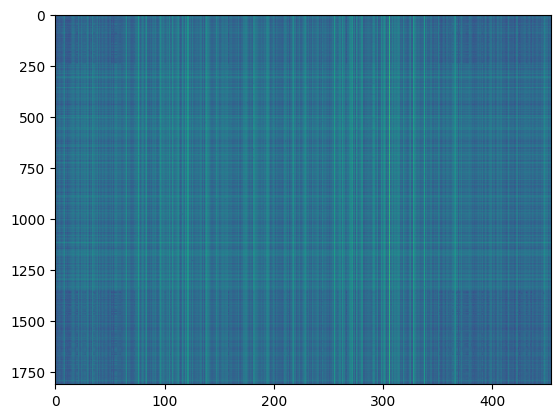

In [49]:
plt.imshow(D[ytr.argsort(), :][:, yts.argsort()], aspect='auto')

we implement the NN classifier idea: we assign labels to test points by looking at its nearest neighbor,

In [50]:
i_opt = D.argmin(axis=0)
y_pred = ytr[i_opt]

we can define how good the classifier is by analyzing its accuracy, or $0-1$ loss. This is defined as follows,

$$acc = \dfrac{1}{n}\sum_{i=1}^{n}\mathbb{1}[y_{i} = \hat{y}_{i}]$$

where $\hat{y}_{i}$ is the label assigned by the classifier to the i-th sample.

In [51]:
acc = (1 * (y_pred == yts)).sum() / len(yts)
print(acc)

0.7202643171806168


We can also analyze the accuracy for each class,

In [52]:
for yu in np.unique(labels):
    ind = np.where(yts == yu)[0]
    acc = (1 * (y_pred[ind] == yts[ind])).sum() / len(yts[ind])
    
    print(f'Class {yu}, acc: {acc}')

Class -1, acc: 0.3442622950819672
Class 0, acc: 0.953405017921147
Class 1, acc: 0.3508771929824561


__Note.__ Since there is class imbalance, the average of class-wise accuracies is not equal to the global accuracy. Since the negative class is under-represented, even though the classifier does not classifies it well, it does not hurt accuracy that much.